In [29]:
# Import libraries

from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm, SPDHG
from cil.optimisation.functions import Function, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox, LeastSquares, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise
from cil.processors import Slicer

import matplotlib.pyplot as plt

import numpy as np

import importlib

In [7]:
# Define functions
import sys
cil_path = '/u/s/cd902/GitHub/Hackathon-000-Stochastic/cil'
sys.path.append(cil_path)
import NewSubsetSumFunction
from NewSubsetSumFunction import SAGAFunction, SGDFunction, SAGFunction, SVRGFunction, LSVRGFunction
import NewFISTA
from NewFISTA import ISTA, FISTA, AdaptiveMomentumISTA

In [8]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

Components: 61
TimeSteps: 1

 Stationary 2D model 12  is selected 


/home/cd902/devel2/build/INSTALL/python/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


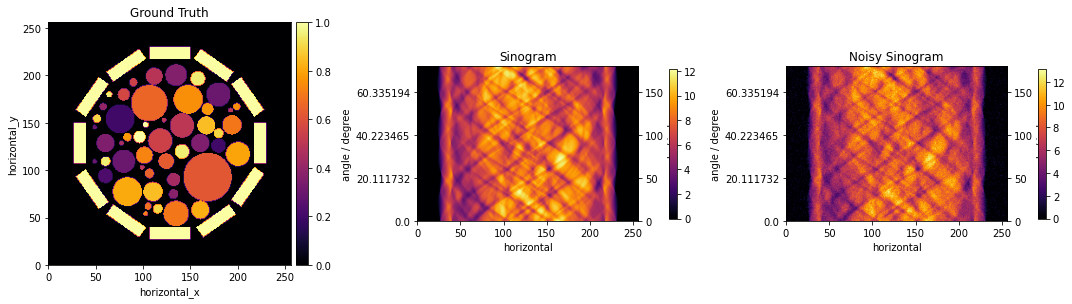

In [9]:
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino.array)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')


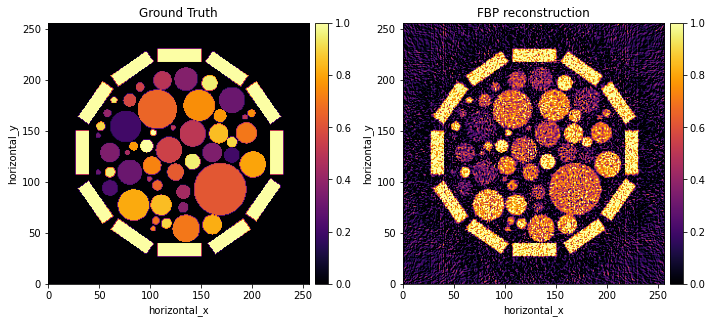

In [10]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'gpu')(noisy_sino)

# Show reconstructions
show2D([phantom, fbp_recon], 
       title = ['Ground Truth','FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

# Setup subset framework 

In [16]:
# Define number of subsets
n_subsets = 10

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = LeastSquares(Ai, b = data_subset)
    f_subsets.append(fi)


# Define F, G and K
F = BlockFunction(*f_subsets)
lb = 0.01
G = lb * TotalVariation(lower=0)
num_epochs = 20

## SAGA

In [25]:
num_epochs = 20
F_saga = SAGAFunction(F)
# admissible step-size is gamma = 1/ (3 max_i L_i)
step_size = 1 / F_saga.Lmax
initial = ig.allocate(0)
F_saga.memory_reset()
saga = ISTA(initial=initial, 
            f=F_saga,
            g=G,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
saga.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured


## SAGFunction, SVRGFunction, LSVRGFunction

In [26]:
F_sag = SAGFunction(F)
initial = ig.allocate(0)
F_sag.memory_reset()
sag = ISTA(initial=initial, 
            f=F_sag,
            g=G,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
sag.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured


In [27]:
F_svrg = SVRGFunction(F)
initial = ig.allocate(0)
F_svrg.memory_reset()
svrg = ISTA(initial=initial, 
            f=F_svrg,
            g=G,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
svrg.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured


In [28]:
F_lsvrg = LSVRGFunction(F)
initial = ig.allocate(0)
F_lsvrg.memory_reset()
lsvrg = ISTA(initial=initial, 
            f=F_lsvrg,
            g=G,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
lsvrg.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured


## SGDFunction

In [30]:
F_sgd = SGDFunction(F)
initial = ig.allocate(0)
sgd = ISTA(initial=initial, 
            f=F_sgd,
            g=G,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
sgd.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured


## SAGA with diagonal preconditioning



In [38]:
# With diagonal preconditioning

# D(x) = diag(x / A^T \1)
num_epochs = 20
cst = A.adjoint(A.range.allocate(1.))
cst2 = ig.allocate(1.).divide(cst)
precond = lambda i, x: cst2
# precond = lambda i, x: x.divide(cst)
# csts = [Ai.adjoint(Ai.range.allocate(1.))  for Ai in A_subsets]
# precond = lambda i, x: x.divide(csts[i]) 
F_saga = SAGAFunction(F, precond=precond)
step_size = 0.1
# initial = ig.allocate(1.)
initial = ig.allocate(0.)
F_saga.memory_reset()
saga_precond = ISTA(initial=initial, 
            f=F_saga,
            g=G,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
saga_precond.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured


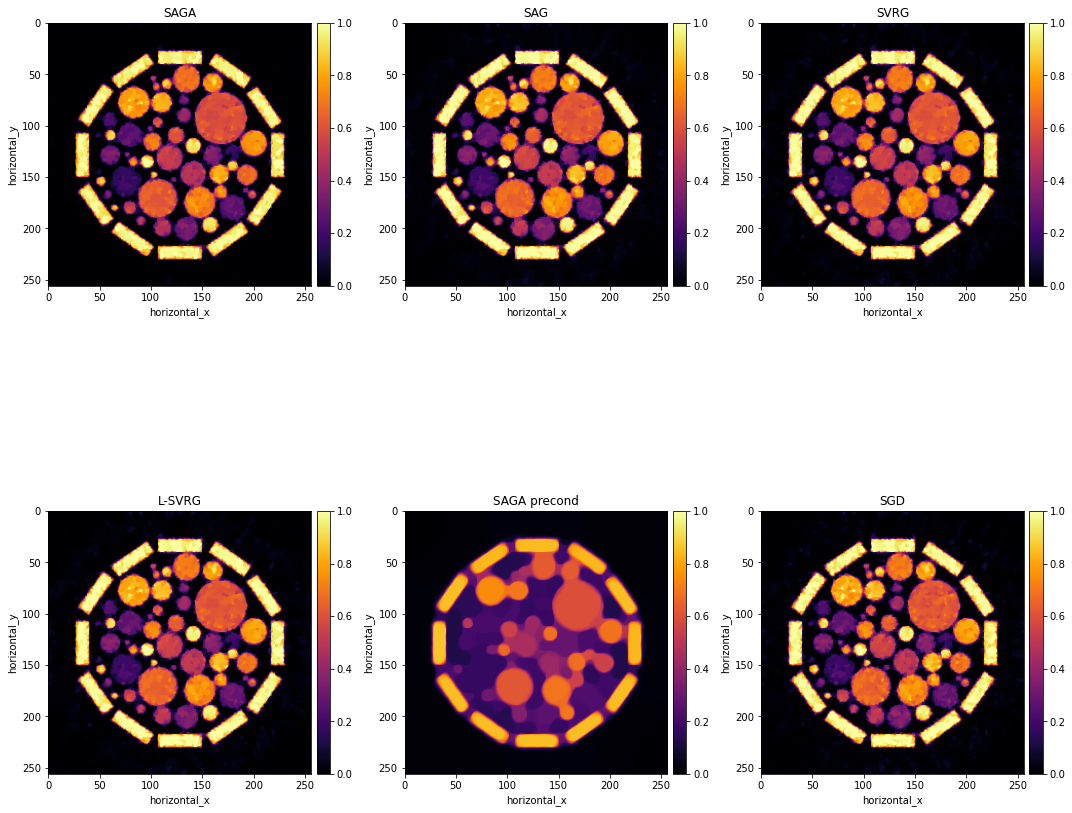

In [39]:
# Look at results
show2D([saga.solution, sag.solution, svrg.solution, lsvrg.solution , saga_precond.solution, sgd.solution], 
       origin="upper", 
       title=["SAGA", "SAG", "SVRG", "L-SVRG", "SAGA precond", "SGD"],
       fix_range=(0,1), num_cols=3,
       cmap='inferno')

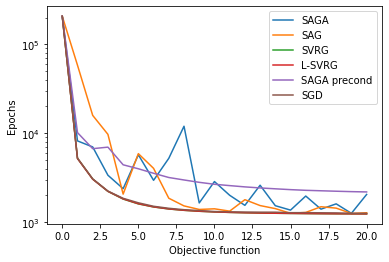

In [40]:
# compare results
plt.figure()
plt.semilogy(saga.objective, label="SAGA")
plt.semilogy(sag.objective, label="SAG")
plt.semilogy(svrg.objective, label="SVRG")
plt.semilogy(lsvrg.objective, label="L-SVRG")
plt.semilogy(saga_precond.objective, label="SAGA precond")
plt.semilogy(sgd.objective, label="SGD")
plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Objective function')
plt.show()